In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve,\
  roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier


In [3]:
# Get the data. No need for a data frame since it's image data
mnist = fetch_openml("mnist_784", as_frame=False)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


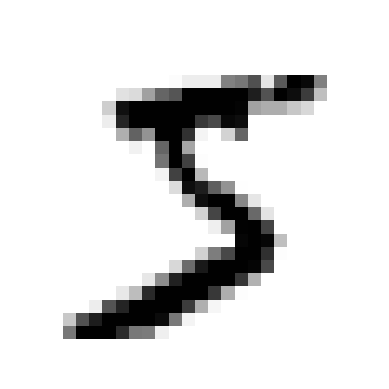

5


In [4]:
# Get data and labels
X, y = mnist.data, mnist.target

# Each instance is an flattened 28x28 = 784 pixel image 
# Each label is a number 0-9
print (X.shape)
print (y.shape)

# Seeing one image as an example
def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()
print (y[0])



In [5]:
# The MNIST dataset is already shuffled and split into train and test datasets. The first 60K images are for 
# training.

# With classification models, it's important that our training set contains an example of each digit. If we were to shuffle
# and split the data ourselves, we would have had to use stratified split with the labels as the stratification parameter.

# In addition to have an example of every image in our training set, the order they appear can affect the training as well.
# Shuffling them to a random order is important.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [6]:
# To start, let's build a simple classifier that can identify 5 or no 5

# This will change the labels to True when the label is 5, False otherwise
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
# Our random 'some_digit' variable (which we know is 5)
sgd_clf.predict([some_digit])

array([ True])

### Measuring Performance

In [9]:
# Using k-fold cross validation to test our 5-only binary classifier

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# We can see high accuracy for the binary 5-only classifier. Does it mean it's a good classifier? Accuracy is not enough. 
# This classifier could have missed many 5's (said no instead of yes), i.e it could have a high number of false negatives.
# Accuracy only tells us the percentage of correct answers (yes or no) out of all answers. High accuracy for a model
# means - when the model gave an answer (yes or no), it was most likely the right answer.

# To see how accuracy is not enough, we can create a dummy classifier which always classifies the most frequent class. In
# our case, the false class. This helps us to establish a baseline
dummy_clf = DummyClassifier()
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# We can see that the dummy model got over 90% accuracy. That's because the number 5 is 10% of the dataset... if you guess
# that an image is not a 5, you'll be correct 90% of the time.


array([0.90965, 0.90965, 0.90965])

In [11]:
# Accuracy is not great performance metric for classifiers and especially not a good one for skewed datasets where there
# is a class imbalance. A better performance metric (or metrics) is the confusion matrix. 

# cross_val_predict returns the actual predictions made in each fold instead of a score. It'll take the most frequent
# prediction out of the k models predictions in the result (you'll get back a single array)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [12]:
# Generate a confusion matrix. It takes the real labels and the predicted labels and returns a matrix:
#
#    | neg` pos`
# neg: TN,  FP 
# pos: FN,  TP 
#
# Notice that each row represents the entire elements of a class. Each column represents predicted elements of a certain class.

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Using the confusion matrix's values we can start computing more insightful metrics:

* Precision: TP / (TP + FP)
  - From all the times the classifier predicted YES, how many of those were correct.
  - Ratio of correct YES to ALL PREDICTED YES 
  - Example, training a model that makes sure a video is safe for kids (YES means safe for kids). You'd care more
    about the precision since it's better to be wrong and censor a video than letting a kid see an unsafe video.
    Here lower recall would mean that the algorithm decided that some safe videos are actually unsafe which is ok.
* Recall: TP / (TP + FN)
  - Given the model's TP count, what's its percentage considering all positives
  - Ratio of correct YES to ALL ACTUAL YES
  - Example, training a model that detects shoplifting (YES means shoplifter). Here high recall would be preferable since
    you don't want to miss shoplifter. Lower precision would mean that the store checks people that aren't shoplifter, 
    which isn't great but not as bad as having stuff stolen.
* F1: 2 * (precision * recall) / (precision + recall)
  - The harmonic mean of precision and recall. Harmonic mean gives more weight to lower values. If precision is high
    and recall is low, the F1 score will get dragged more to the lower end.
  - F1 favors classifiers that have similar precision and recall. 

The precision/recall tradeoff: Increasing precision reduces recall and vice versa.
  * The reason is because models that classify compute a probability that an instance belongs to a class 
    and then use a threshold on that probability to make a decision.
  * Reducing this threshold would make the model say YES more easily, hence increasing the recall (it throws a wider
    net, catching more stuff but also junk - FPs).
  * Increasing this threshold would make the model say NO more easily, hence increasing the precision (it throws a
    small, more targeted net, catching less things - more FNs - but the stuff it does catch are more likely
    tp be true).


In [13]:
# Precision is 83% - meaning, when it says YES, it's correct 83% of the time
print ("Precision:", precision_score(y_train_5, y_train_pred))

# Recall is 65% - meaning all the YES it said covered 65% of the actual YES examples
print ("Recall:", recall_score(y_train_5, y_train_pred))

print ("F1: ", f1_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1:  0.7325171197343846


In [14]:
# The precision / recall tradeoff

# The SGD classifier does not let you change the threshold, instead it lets you get the confidence for each prediction
# and you can combine it with a threshold to make decisions

y_scores = sgd_clf.decision_function(X_train)
threshold = 3000
y_pred_after_threshold = (y_scores >= threshold)
print ("Precision threshold 3000:", precision_score(y_train_5, y_pred_after_threshold))
print ("Recall threshold 3000:", recall_score(y_train_5, y_pred_after_threshold))

threshold = 6000
y_pred_after_threshold = (y_scores >= threshold)
print ("Precision threshold 6000:", precision_score(y_train_5, y_pred_after_threshold))
print ("Recall threshold 6000:", recall_score(y_train_5, y_pred_after_threshold))

# This shows how increasing the prediction threshold increases precision and reduces recall. 
# Think of it as the inverse to the size of the net thrown - higher threshold, smaller net and vice versa

Precision threshold 3000: 0.9390070921985816
Recall threshold 3000: 0.610588452315071
Precision threshold 6000: 0.9829619921363041
Recall threshold 6000: 0.27670171555063644


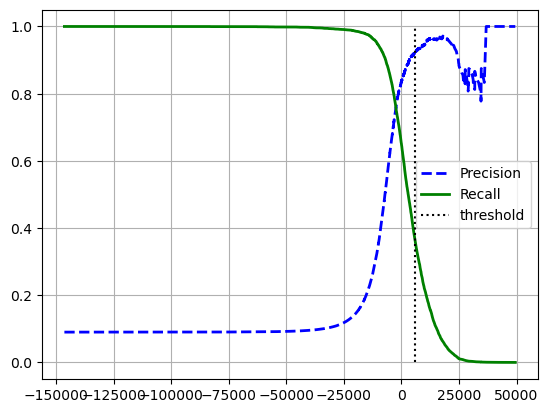

In [15]:
# How do we know which threshold to use?

# We want to find the threshold that fits our problem's needs (see recall and precision examples).

# We can use the classifier's decision_function as a metric for the cross val function. This will return the aggregated
# scores from all k folds
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# The we can get a precision recall curve and plot it
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend()
plt.grid()
plt.show()

### The precision / recall curve

This curve plots the precision as a function of recall. It clearly shows the tradeoff between the two. This curve is great for when we 
care about precision more.

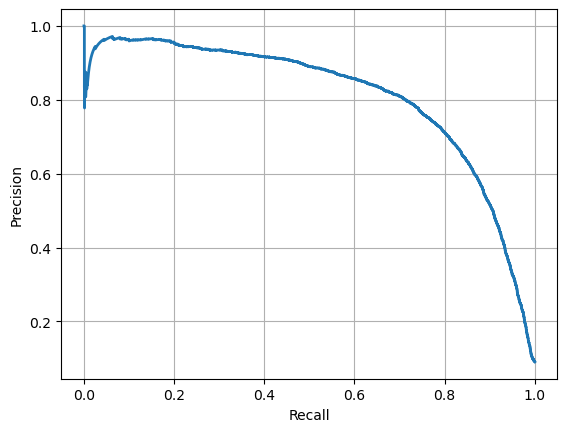

In [16]:
# Another way to plot it is to have the precision as a function of the recall
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


In [17]:
# Now that you saw the curve and you're ready to get the right threshold for your project, you do the following (getting
# it from the curve is not accurate):

# Assume that you want to find the threshold that'll keep precision at 90%
# The precisions and recalls array are sorted in ascending order. This means that if we find the first threshold over 90%
# precision, we can use it

# Get the index of the first precision over 90%
precision_wanted = 0.9

# get array of true when the value is over 0.9, false otherwise
precisions_over_val = (precisions >= precision_wanted)

# get the index of the first max value (index of the first True)
precision_over_val_idx = np.argmax(precisions_over_val >= precision_wanted)

# get the threshold at that index
threshold_precision_val = thresholds[precision_over_val_idx]

# now to get a prediction, instead of calling predict on the classifier, we call the decision_function and use our threshold
digits_to_predict = X_train[40:50]
digits_to_predict_scores = sgd_clf.decision_function(digits_to_predict)
predictions = (digits_to_predict_scores >= threshold_precision_val)
actuals = y_train[40:50]

df = pd.DataFrame([[predictions.astype(int), actuals]])
df.T


,0
0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,"[1, 8, 7, 9, 3, 9, 8, 5, 9, 3]"


### The ROC Curve

Plots the true positive rate (recall) against the false positive rate (FPR). This type of curve is excellent when we care more
about recall. 

The FPR is the ratio of negative instances that were incorrectly classified as positive: FP / (FP + TN).

Notice the tradeoff - the higher the recall (the higher the ratio of true positives to false negatives), the higher the 
false positive rate. This is another way to see that increasing the recall (increasing the fishing net size), brings us 
more true positives but also more junk (false positives).

The ROC curve helps us see the threshold value for recall that produces less false positives.

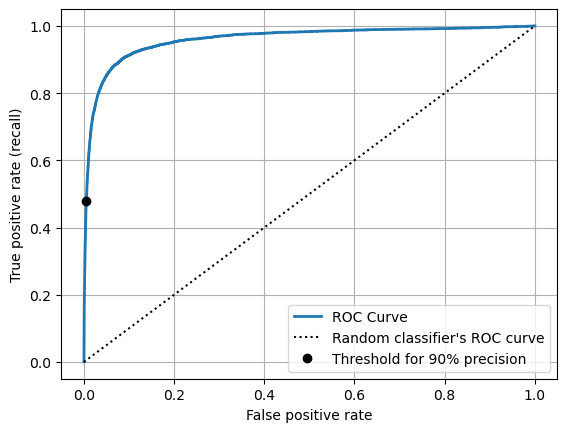

In [22]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# finding the decision function's threshold that produces 90% precision.
# Using the threshold from the precision/recall curve for 90% precision, we find the index in the tpr and fpr arrays that
# would generate 90% precision.
idx_for_threshold_at_90 = (thresholds <= threshold_precision_val).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0,1], [0,1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], 'ko', label="Threshold for 90% precision")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (recall)")
plt.grid()
plt.legend()
plt.show()

In [35]:
# One way to measure the goodness of an ROC curve is to compute the area under the curve of it (AUC).
# The closer the AUC to 1, the better. The closer the AUC to 0.5, the more random the classifier is.

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [38]:
# Creating a new classifier for the only-digit-5 classification problem so that we can compare the two

# RandomForestClassifier doesn't have a decision function, instead it has a predict_proba function that returns the 
# probabilities for each instance.
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [39]:
# The result of the predict_proba method is a table that for each instance, it returns the NO and YES probabilities.

# For example, This shows that for instance 1, the probability for 5 is 89%. For instance 2, it's 2%
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

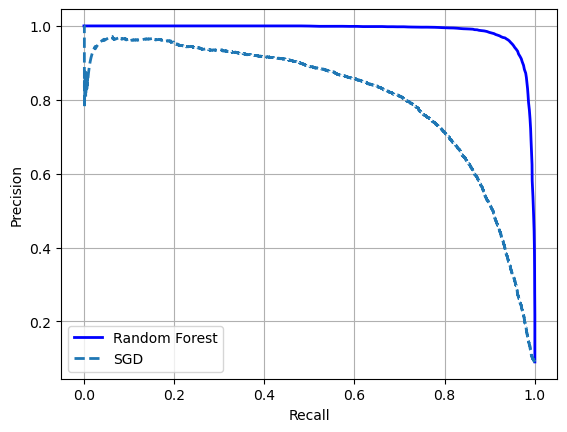

In [42]:
# We would like to plot the YES probabilities of the forest classifier next to the SGD classifier on the precision/recall curve

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [43]:
# Looks like the Random Forest model performs much better. We confirm it by computing the ROC and AUC for it

roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

# Multiclass Classification

* One-versus-all (OvA)
  - This is a technique to make any binary classifier work for more than two classes.
  - Say you have 10 classes, you train 10 binary classifiers, one for each class. Each classifier can say YES for the class it
    works on and NO if it's not.
  - Then when we want to classify an image, we get a score from each classifier and choose the one with the highest confidence.
* One-versus-one (OvO)
  - Another technique to make any binary classifier work for more than two classes.
  - Here we train each binary classifier to distinguish between 2 instances. For example, classifier 1 will classify [0,1], 
    classifier 2  [0,2], classifier 3 [0,3], ..., classifier 45 [9,10].
  - For n classes, we'll need [n * (n - 1)] / 2 classifiers. For 10 classes - 10 * (10 - 1) / 2 = 45.
  - The main advantage of OvO is that each classifier only trains on the subset of the data that is relevant to it. For example, 
    a classier that distinguishes between 4 and 5, only needs to train on the examples that are labeled as 4 or 5.
    * There is a class of algorithms (SVM based) that scale poorly with the size of the dataset and it's faster to train
      many classifiers rather than a few on a larger dataset.
    * For all other algorithms, OvA is preferred.
  - When we want to classify an image, we run it in all n classifiers and see which class wins the most duels. For example, 
    classifying the digit 4 should win the class 4 in all classifiers that deal with 4 (e.g [0,4], [1,4], [2,4], etc...)




In [50]:
# Scikit learn detects when you run a binary classifier for multiple classes and automatically runs OvR or OvO, depending on the
# algorithm. For example,

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [54]:
# Now when we make a prediction on an object, sklearn does OvO (in this case) automatically and returns the result. 
# The code makes 45 predictions and selects the class that won most duels.
print (svm_clf.predict([some_digit]))

#  When calling svm_clf.decision_function, we get back 10 scores, one per class. Each class gets a score equal to the number of
# of won duels plus a minor tweak based on the value of the probabilities themselves 
# (e.g class 2 won 4 duels - 4 + tweak(probs[2]) = 4.21).
# The tweak is a function that takes the probabilities of the won duels and maps them to a number in the range [-0.33,0.33]. 
# Higher probabilities in won duels will affect the tweak function directly.
some_digit_scores = svm_clf.decision_function([some_digit])

# We interpret this array like this: class 0 won 4 duels (with tweak reducing 0.21), class 1 won 1, class 3 won 6, etc. Class 5 won 9 
# duels.
print (some_digit_scores.round(2))

# map from index of the winning class to the class label
class_id = some_digit_scores.argmax()
print (svm_clf.classes_[class_id])

['5']
[[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]
5


In [60]:
# We can get better results by scaling the input before training

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
print ("Done scaling...")

forest_clf = RandomForestClassifier(random_state=42)

cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", verbose=10)

Done scaling...
[CV] START .....................................................................
[CV] END ................................ score: (test=0.964) total time=  13.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   13.7s


[CV] END ................................ score: (test=0.963) total time=  13.8s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.966) total time=  14.0s


array([0.96425, 0.9627 , 0.9661 ])

# Error Analysis

### Confustion matrix

In [65]:
# Same as with the binary classifier, we can get a confusion matrix for the multiclass classifier's predictions.

y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)


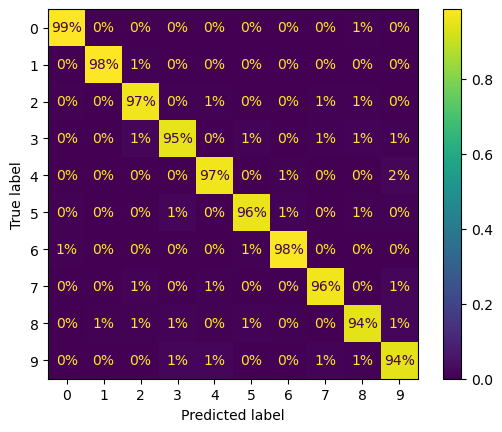

In [73]:
# Each row represents the class actual and each column the class prediction.
# The diagonal of the matrix represents the correct predictions. 
# We can see the types of mistakes that the model is making. For example, 1% of the time the model predicted 5 when the true label
# was 8.

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

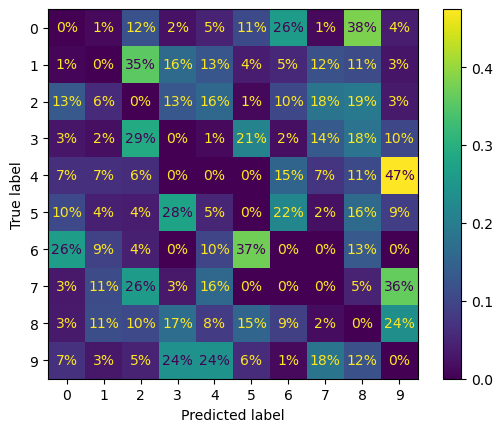

In [82]:
# Emphasizing the errors in the confusion matrix by adding weights to all WRONG predictions. To do that, we get a boolean array
# where the wrong predictions are TRUE, correct predictions are FALSE. This will give a weight of 0 to correct predictions and a weight
# 1 to wrong predictions
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")

# Now notice that the main diagonal (correct predictions) is all 0% (0 weight * percentage). The prediction errors (all other cells)
# are now easily seen since the normalization is not affected by the correct predictions (which are the majority by a lot).

# Notice that the normalization is at the row level - at the actual label level

# We can see the most common mistakes:
#   - 47% of the prediction errors the model made on number 9 are that it classified it as 4
#   - 36% of the prediction errors the model made on number 9 are that it classified it as 7
# and so on...

# We can gain insights from this matrix on how to improve this model. For example, we could get more images that look like
# 9 so that the model better distinguishes 9 from other digits.


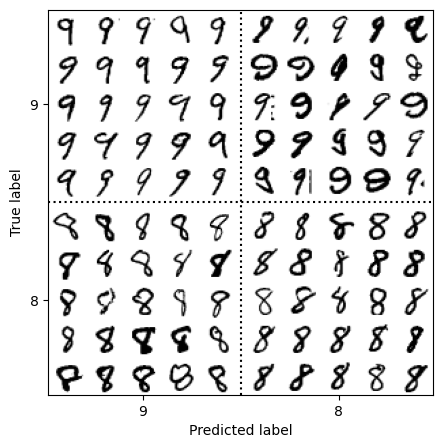

In [88]:
# We can plot some examples (see images) where the model confused one digit for another

cl_a, cl_b = '9', '4'

# All actual examples equal to a that were predicted correctly
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 

# All actual examples equal to a that the classifier mispredicted as b
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]

# All actual examples equal to b that the classifier mispredicted as a
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

# All actual examples equal to b that were predicted correctly
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] 


size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary", extent=(x, x + 1, y, y + 1))
        
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Multilabel Classification

These are problems where each instance maps to multiple labels. For example, assume a classifier that learns to recognize the
faces of 3 people: Alice, Bob, Charlie. When it's presented with an image of Alice and Charlie, it'll output: [True, False, True].

Not every classifier supports a multilabel output.

In [95]:
# An example for a multilabel classification problem 

# We'll use the digits labels to build a multilabel output. Instead of a classifier outputting the digit label, it will
# output if it's above 7 (large) and if it's odd



y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 != 0)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [96]:
# Making a multilabel prediction

# some_digit == 5
knn_clf.predict([some_digit])

array([[False,  True]])

### Evaluating a multilabel classifier

One way to evaluate a multilabel classifier is to compute a score (e.g F1) for each one of the labels and then taking 
the average.

In [97]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# macro takes the average of the labels with equal weights. This is good when the labels are balanced (e.g same number of odd 
# and number greater than 7). 
# If the labels are not balanced, using average="weighted" will give weights to each class according to the class distribution
# so that the average is not swayed by the dominant class.
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

This is a generalization of multilabel classification. Here each class in the multilabel output can have more values than 
T/F. 

An example for such multioutput classifier is a system that removes noise from images. The output of this classifier is a label
for each pixel that has 255 values (the pixel's intensity).

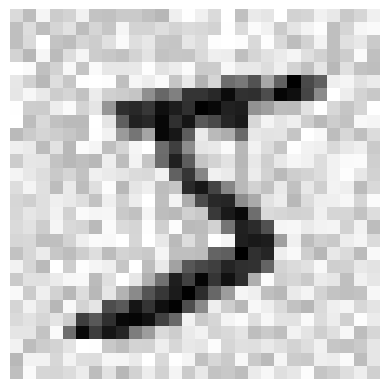

In [100]:
# Image noise reduction classifier example (multioutput)

# Adding noise to the image training set
np.random.seed(42)

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

plot_digit(X_train_mod[0])

In [102]:
# The labels are non-noisy images (not the digit labels anymore...)
y_train_mod = X_train
y_test_mod = X_test

# Training the classifier to map noisy to non-noisy images
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

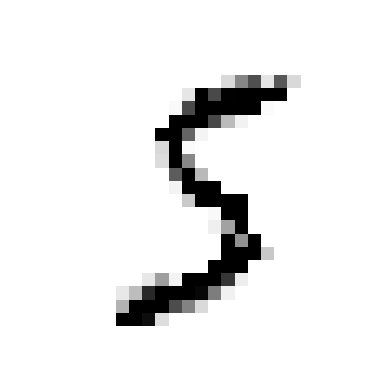

In [103]:
# Plotting the same digit as above after passing it thru the noise reduction classifier
clean_digit = knn_clf.predict([X_train_mod[0]])
plot_digit(clean_digit)